# 2024-07-01 · AdExNet-Brian

Using Brian to simulate a network of spiking neurons (specifically: conductance-based (COBA) adaptive exponential (AdEx) integrate and fire neurons).

In [1]:
from brian2 import *

## Neuron model

Copying from https://github.com/tfiers/phd/blob/main/nb/pylib/neuron.py :

Parameters for a cortical regular spiking (RS) neuron, from Naud 2008.

In [2]:
C   = 104  * pF
gL  = 4.3  * nS
EL  = -65  * mV
VT  = -52  * mV
DT  = 0.8  * mV
Vs  =  40  * mV
Vr  = -53  * mV
a   = -0.8 * nS
b   =  65  * pA
tau_w = 88 * ms

Ee  =   0  * mV
Ei  = -80  * mV
tau_g = 7  * ms;

Strength of noisy external input current:

In [3]:
Iext = 8 * pA * sqrt(second)

8.e-12 * second ** 0.5 * amp

In [4]:
eqs = """
dV/dt = ( -gL*(V - EL) + gL * DT * exp((V-VT)/DT) -I -w -(Iext * xi)) / C : volt
dw/dt = (a*(V - EL) - w) / tau_w : amp

I = ge * (V - Ee) + gi * (V - Ei) : amp

dge/dt = -ge / tau_g : siemens
dgi/dt = -gi / tau_g : siemens
""";

In [5]:
def COBA_AdEx_neuron(N = 1):
    G = NeuronGroup(
        N, eqs, threshold="V > Vs", reset="V = Vr; w += b", method='euler',
    )
    G.V = EL
    # Rest of vars are auto set to 0
    return G

In [6]:
COBA_AdEx_neuron()

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

Num neurons.

In [7]:
N = 100;

Number of excitatory neurons:

In [8]:
Ne = N * 4//5

80

In [9]:
G = COBA_AdEx_neuron(N)  # NeuronGroup

Ge = G[:Ne]
Gi = G[(Ne+1):];

## Connectivity

In [10]:
delay = 0 * ms

p_conn = 0.05

we = 10 * nS / (N*p_conn)  # Based on pkgs Nto1AdEx, and VoltoMapSim

wi = 4*we;

In [11]:
seed(1234)

In [12]:
Se = Synapses(Ge, G, on_pre="ge += we", delay=delay)
Si = Synapses(Gi, G, on_pre="gi += wi", delay=delay);

In [13]:
prefs.codegen.target = "numpy"  # Until we have enough internet to download C++ build tools ('visual studio').

In [14]:
Se.connect(condition='i != j', p=p_conn)
Si.connect(condition='(i+Ne+1) != j', p=p_conn)

Convert to connection matrix.

In [15]:
W = np.zeros((N,N), dtype=int)

for (i,j) in zip(Se.i, Se.j):
    W[i,j] = 1

for (i,j) in zip(Si.i, Si.j):
    i += (Ne+1)  # Offset for the inhibitory 'from' neurons
    W[i,j] = -4

W

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

A sanity check:

In [16]:
np.count_nonzero(W) / np.size(W)

0.0488

Save to disk.

In [17]:
data_dir = "../data/2024-07-01__AdExNet-Brian/";

import os
os.makedirs(data_dir, exist_ok=True)

np.save(data_dir + "connectivity_matrix.npy", W)

## Simulate net

In [18]:
M = StateMonitor(G, ["V"], record=[0])
S = SpikeMonitor(G)
net = Network(G, Se, Si, M, S);

In [19]:
T = 60 * second;

In [20]:
net.run(T, report='stdout', report_period=10*second)

Starting simulation at t=0. s for a duration of 60. s
7.8048 s (13%) simulated in 10s, estimated 1m 7s remaining.
16.2596 s (27%) simulated in 20s, estimated 54s remaining.
24.8611 s (41%) simulated in 30s, estimated 42s remaining.
33.5618 s (55%) simulated in 40s, estimated 32s remaining.
42.116 s (70%) simulated in 50s, estimated 21s remaining.
50.6588 s (84%) simulated in 1m 0s, estimated 11s remaining.
59.2927 s (98%) simulated in 1m 10s, estimated 1s remaining.
60. s (100%) simulated in 1m 10s


Save spike trains to disk.

In [21]:
trains = {}
for (i,train) in S.spike_trains().items():
    trains[f"neuron_{i}"] = train / second

trains["neuron_0"]

array([ 0.0981,  0.2154,  0.4087,  0.8497,  0.8514,  1.2013,  1.5335,
        1.5479,  1.7766,  1.9157,  2.2367,  2.3956,  2.6073,  2.6266,
        2.8691,  2.8704,  3.2107,  3.6489,  3.7416,  4.0888,  4.7359,
        4.7523,  5.2979,  5.5197,  5.6059,  5.6559,  6.0879,  6.3774,
        6.6031,  6.6055,  6.6094,  7.0454,  7.4738,  7.733 ,  8.1622,
        8.1809,  8.9604,  9.231 ,  9.787 , 10.0557, 10.3248, 10.5081,
       11.0537, 11.3813, 11.3848, 11.5985, 11.9418, 12.0614, 12.5731,
       13.0706, 13.1415, 13.4369, 13.7976, 14.2316, 14.6229, 14.8934,
       15.121 , 15.1301, 15.1887, 15.1938, 15.9013, 15.9265, 16.2067,
       16.2113, 16.3349, 16.5827, 16.8747, 17.319 , 17.3577, 17.5984,
       17.9209, 17.9249, 17.9301, 18.4096, 18.5597, 18.6846, 19.0331,
       19.2043, 19.5641, 19.8067, 19.8588, 19.8636, 20.2356, 20.2536,
       20.7705, 21.2847, 21.5383, 21.9267, 21.9302, 22.081 , 22.4182,
       22.8306, 22.9873, 23.0414, 23.3584, 23.6576, 23.7582, 23.948 ,
       23.9501, 24.1

In [22]:
np.savez(data_dir + "spiketimes.npz", **trains)

In [23]:
%run pylib/plot.py

importing mpl … ✔
importing brian … ✔


In [24]:
def ceil_spikes_brian(M: StateMonitor, S: SpikeMonitor, var='V', n=0, V_ceil=Vs):
    "For nice plots, set the voltage trace to some constant at spike times"
    V = getattr(M, var)[n]
    spikes = S.t[S.i == n]
    return ceil_spikes(V, M.t, spikes, V_ceil)

def ceil_spikes(V, t, spiketimes, V_ceil=Vs):
    "For nice plots, set the voltage trace to some constant at spike times"
    i = searchsorted(t, spiketimes)
    V[i] = V_ceil
    return V

Voltage of one (excitatory) neuron:

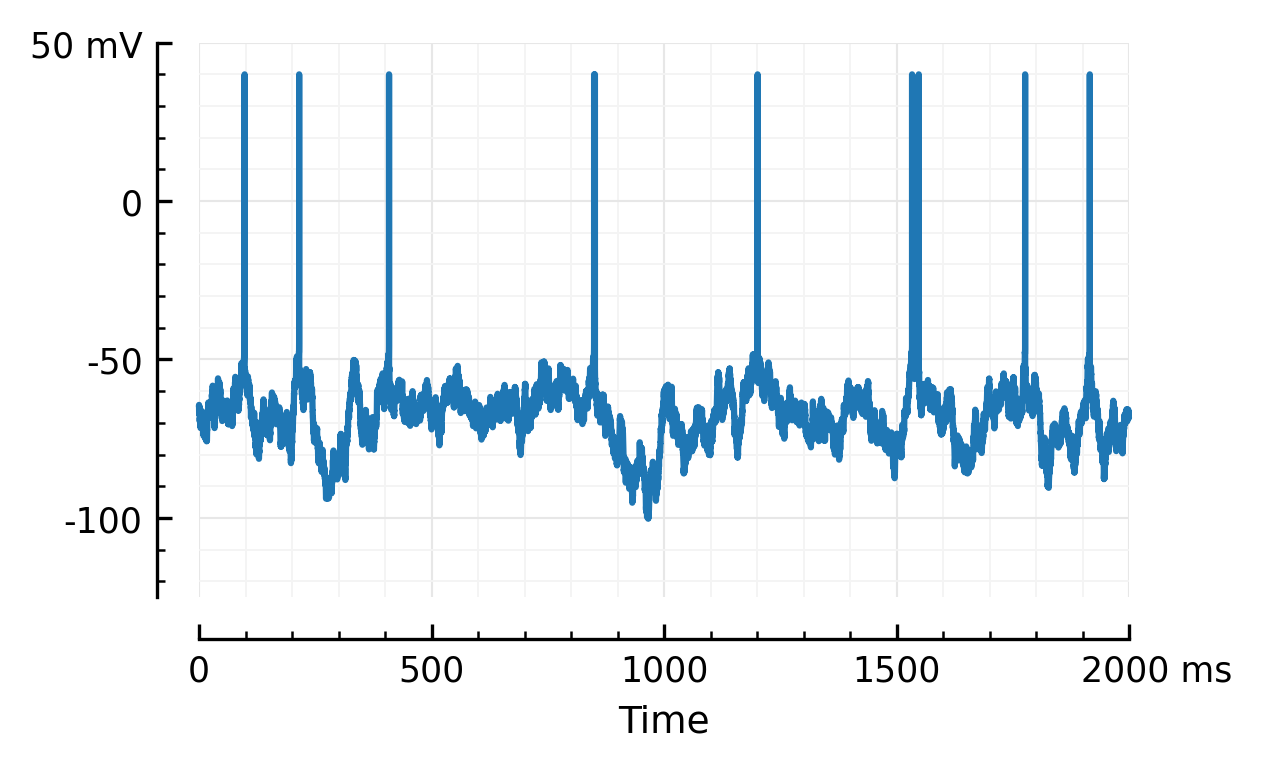

In [25]:
plotsig(ceil_spikes_brian(M, S), tlim=[0, 2]*second);

Rasterplot:

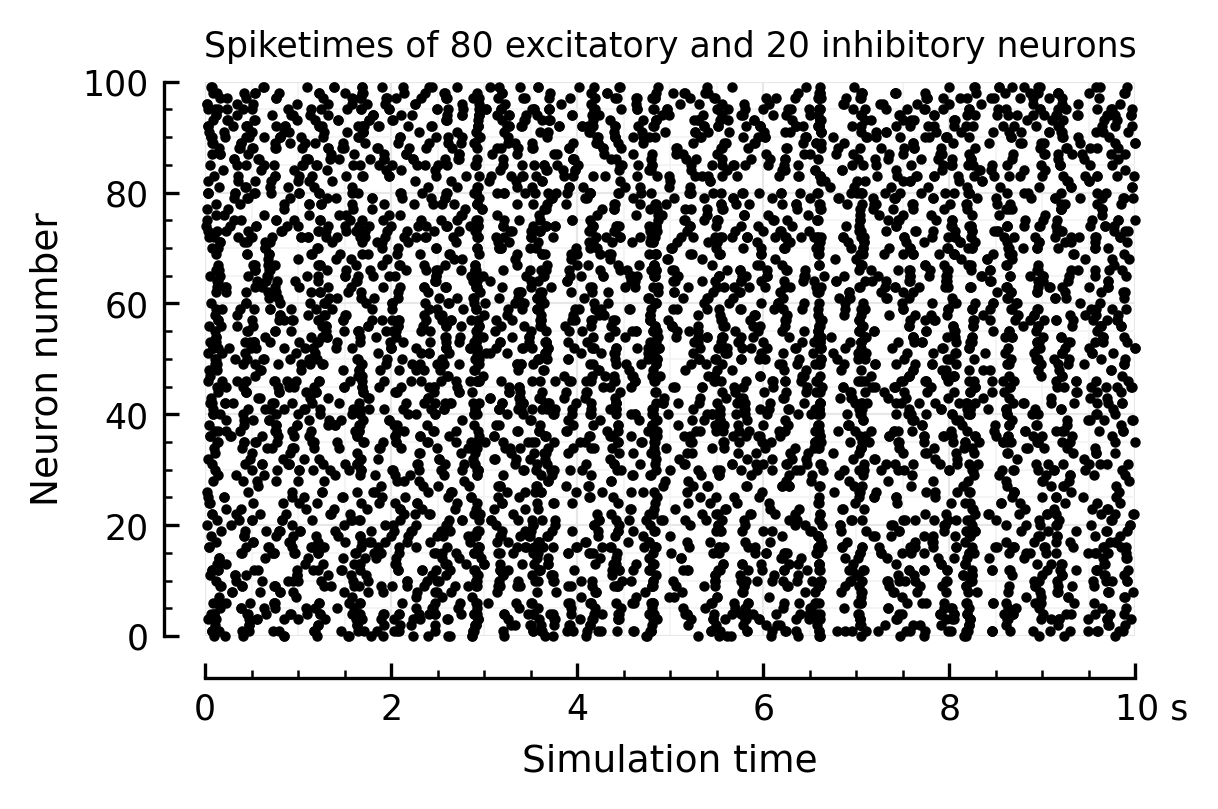

In [26]:
tmax = 10*second
sel = S.t < tmax
ax = plot(
    S.t[sel], S.i[sel], "k.", xlim=[0, tmax], ylim=[0, N], ms=3,
    ylabel="Neuron number", xlabel="Simulation time",
)
ax.set_title(f"Spiketimes of {Ne} excitatory and {N - Ne} inhibitory neurons", fontsize="small");